# figures for appendix examining $z$ failure

In [2]:
import os
import numpy as np 
from scipy.special import erf
from astropy.table import Table
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

## read ztile file for BGS with rmag, rfib, and zsuccess appended

In [3]:
bgs = Table.read('/tigress/chhahn/provabgs/svda/ztile-sv3-bright-cumulative-bgsbright.fits')

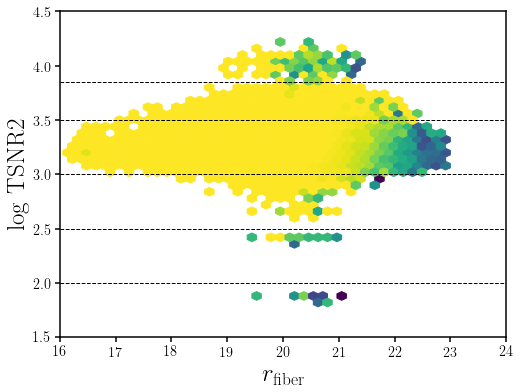

In [12]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
sub.hexbin(bgs['rfib'] , np.log10(bgs['TSNR2_BGS']), C=bgs['zsuccess'], reduce_C_function=np.mean, 
           gridsize=50, vmin=0.0, vmax=1, mincnt=2)
sub.plot([16, 24], [2.0, 2.0], c='k', lw=1, ls='--')
sub.plot([16, 24], [2.5, 2.5], c='k', lw=1, ls='--')
sub.plot([16, 24], [3.0, 3.0], c='k', lw=1, ls='--')
sub.plot([16, 24], [3.5, 3.5], c='k', lw=1, ls='--')
sub.plot([16, 24], [3.85, 3.85], c='k', lw=1, ls='--')
sub.set_xlabel(r'$r_{\rm fiber}$', fontsize=25)
sub.set_xlim(16, 24)
sub.set_ylabel(r'$\log$ TSNR2', fontsize=25)
sub.set_ylim(1.5, 4.5)
fig.savefig('../figs/bgs_bright_rfib_tsnr2.pdf', bbox_inches='tight')

## figure comparing $z$-success rate as a function $r_{\rm fib}$ for each category

In [14]:
def zsuccess_rate(prop, zsuccess_cond, range=None, nbins=20, bin_min=2):
    ''' measure the redshift success rate along with property `prop`
    :params prop: 
        array of properties (i.e. Legacy r-band magnitude) 
    :params zsuccess_cond:
        boolean array indicating redshift success 
    :params range: (default: None) 
        range of the `prop` 
    :params nbins: (default: 20) 
        number of bins to divide `prop` by 
    
    :params bin_min: (default: 2)  
        minimum number of objects in bin to exlcude it 
    :return wmean: 
        weighted mean of `prop` in the bins 
    :return e1: 
        redshift success rate in the bins
    :return ee1: 
        simple poisson error on the success rate
    '''
    h0, bins = np.histogram(prop, bins=nbins, range=range)
    hv, _ = np.histogram(prop, bins=bins, weights=prop)
    h1, _ = np.histogram(prop[zsuccess_cond], bins=bins)
    
    good = h0 > bin_min
    hv = hv[good]
    h0 = h0[good]
    h1 = h1[good]

    wmean = hv / h0 # weighted mean 
    rate = h1.astype("float") / (h0.astype('float') + (h0==0))
    e_rate = np.sqrt(rate * (1 - rate)) / np.sqrt(h0.astype('float') + (h0 == 0))
    return wmean, rate, e_rate

def func_zsuccess(rfib, c_erf0, c_erf1): 
    return 0.5*(1-erf(c_erf0*(rfib - c_erf1)))

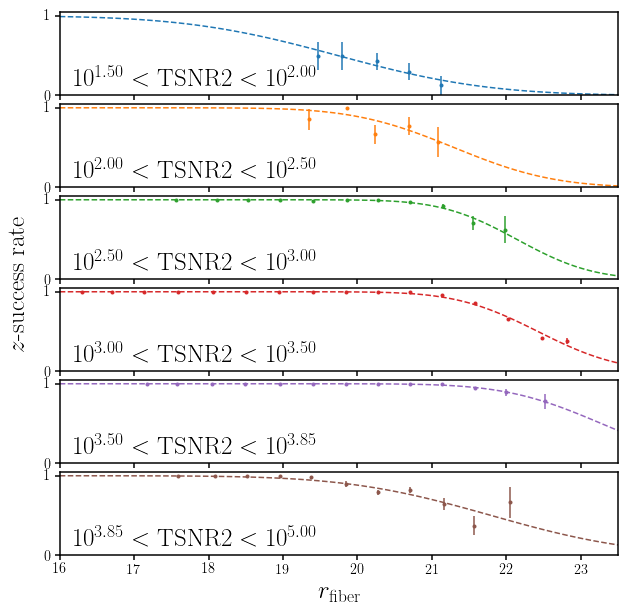

In [25]:
rfib_bin = np.linspace(16, 25, 101)
c_erf0s = [0.4427206285293464, 0.6680558239013213, 0.887764152826012, 0.8221052010907632, 0.6977389907480749, 0.46515502891632765]
c_erf1s = [19.740614342105797, 21.30081137449924, 22.148672072673186, 22.429172673344308, 23.28073097346122, 21.804219249288696]

fig = plt.figure(figsize=(10,10))
for i, logtsnr0, logtsnr1 in zip(range(6), [1.5, 2.0, 2.5, 3.0, 3.5, 3.85], [2.0, 2.5, 3.0, 3.5, 3.85, 5.0]):
    sub = fig.add_subplot(6,1,i+1)
    
    logtsnr_lim = (np.log10(bgs['TSNR2_BGS']) > logtsnr0) & (np.log10(bgs['TSNR2_BGS']) < logtsnr1)
    
    rfib_mid, zsrate, e_zsrate = zsuccess_rate(bgs['rfib'][logtsnr_lim], bgs['zsuccess'][logtsnr_lim], 
                                               range=(16, 25), nbins=20, bin_min=5)
    sub.errorbar(rfib_mid, zsrate, yerr=e_zsrate, fmt='.C%i' % i)
    sub.text(0.025, 0.05, r'$10^{%.2f} < {\rm TSNR2} < 10^{%.2f}$' % (logtsnr0, logtsnr1), 
             ha='left', va='bottom', fontsize=25, transform=sub.transAxes)
    
    sub.plot(rfib_bin, func_zsuccess(rfib_bin, c_erf0s[i], c_erf1s[i]), c='C%i' % i, ls='--')
    sub.set_xlim(16, 23.5)
    sub.set_ylim(0., 1.05)
    if i < 5: sub.set_xticklabels([])
    
fig.subplots_adjust(hspace=0.1)
bkgd = fig.add_subplot(111, frameon=False)
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
bkgd.set_xlabel(r'$r_{\rm fiber}$', fontsize=25)
bkgd.set_ylabel(r'$z$-success rate', fontsize=25)
fig.savefig('../figs/bgs_bright_rfib_tsnr2_zsuccess.pdf', bbox_inches='tight')